In [ ]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [ ]:
X, Y = sklearn.datasets.make_blobs(centers=2, random_state=3)
X = scale(X)

In [ ]:
plt.scatter(X[:, 0], X[:, 1])

In [ ]:
X_unc = np.ones_like(X) * 1.
X_unc[:, 0] = .5

In [ ]:
prob.tag.test_value.shape

In [39]:
with pm.Model() as logistic_regression:
    inputs = pm.Normal('inputs', mu=X, sd=X_unc, shape=X.shape)
    coeffs = pm.Normal('beta', mu=0, sd=1, shape=2)
    
    linear = pm.math.dot(inputs, coeffs)
    prob = pm.math.sigmoid(linear)
    obs = pm.Bernoulli('obs', p=prob, observed=Y)
    
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mean_field = pm.fit(method='advi', n=50000,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])
    
    out_sample = (mean_field.sample_node(prob, size=100, more_replacements={inputs: grid_2d}) > .5)


ValueError: Input dimension mis-match. (input[0].shape[0] = 100, input[1].shape[0] = 1000)

NameError: name 'X1_grid' is not defined

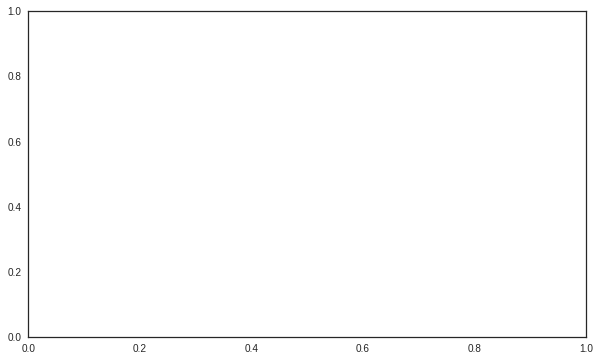

In [12]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.choose_light_palette(250, 12)#, as_cmap=True)#, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [14]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)

In [15]:
def uncertainty_surf(x, a=(2, 3), b=(.2, .3), min_val=.1):
    out_1 = a[0] + x[:, 0] * b[0] 
    out_2 = a[1] + x[:, 1] * b[1]
    out_1[out_1 < min_val] = min_val
    out_2[out_2 < min_val] = min_val
    return np.dstack([out_1, out_2])[0, ...]

In [16]:
X.shape

(1000, 2)

In [17]:
X_uc = uncertainty_surf(X)
X_uc.shape

(1000, 2)

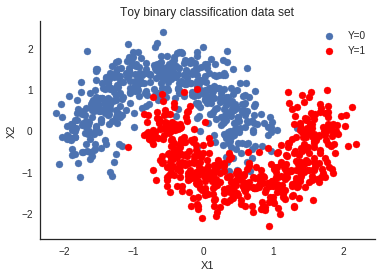

In [18]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

In [19]:

X_uc

array([[ 2.35556116,  3.18227683],
       [ 2.29235303,  2.86573431],
       [ 1.83620546,  3.18221856],
       ..., 
       [ 1.96900957,  2.50669307],
       [ 1.92888424,  2.89662248],
       [ 1.99622199,  2.56440378]])

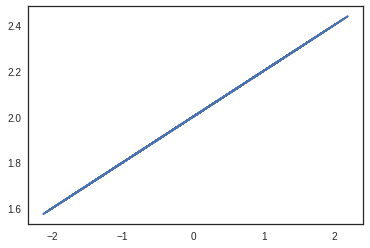

In [20]:
plt.plot(X[:, 0], X_uc[:, 0])

In [21]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], linewidths=X_uc[])
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

SyntaxError: invalid syntax (<ipython-input-21-652fe7560589>, line 2)

In [22]:
out_sample.eval().shape

NameError: name 'out_sample' is not defined

In [23]:
n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

#input_dist = theano.shared(X)

with pm.Model() as neural_network:
    input_dist = pm.Normal('inputs', mu=X, sd=X_uc*.1, 
                           shape=X.shape)
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden lay2er to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(input_dist, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=Y)

In [24]:
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mean_field = pm.fit(method='advi', n=50000,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])

Average Loss = 227.32: 100%|██████████| 50000/50000 [01:18<00:00, 633.34it/s]
Finished [100%]: Average Loss = 227.4


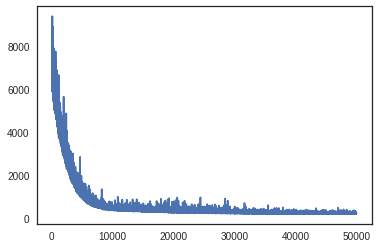

In [26]:
plt.plot(mean_field.hist);

In [27]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X1_grid, X2_grid = grid

In [28]:
with neural_network:
    out_sample = (mean_field.sample_node(act_out, size=100, more_replacements={input_dist: grid_2d}) > .5)

In [29]:
out_sample.eval().std(axis=0)

array([ 0.        ,  0.        ,  0.31288976,  0.4142463 ,  0.        ,
        0.14      ,  0.        ,  0.14      ,  0.        ,  0.        ,
        0.        ,  0.21794495,  0.        ,  0.34698703,  0.        ,
        0.25514702,  0.14      ,  0.23748684,  0.28618176,  0.2712932 ,
        0.3       ,  0.        ,  0.09949874,  0.        ,  0.        ,
        0.        ,  0.48280431,  0.19595918,  0.17058722,  0.35707142,
        0.        ,  0.23748684,  0.        ,  0.        ,  0.        ,
        0.        ,  0.17058722,  0.        ,  0.14      ,  0.        ,
        0.        ,  0.3       ,  0.14      ,  0.36660606,  0.        ,
        0.        ,  0.        ,  0.21794495,  0.        ,  0.        ,
        0.19595918,  0.        ,  0.21794495,  0.09949874,  0.        ,
        0.19595918,  0.        ,  0.        ,  0.        ,  0.14      ,
        0.21794495,  0.3756328 ,  0.        ,  0.14      ,  0.        ,
        0.09949874,  0.        ,  0.47021272,  0.19595918,  0.3 

ValueError: cannot reshape array of size 1000 into shape (100,100)

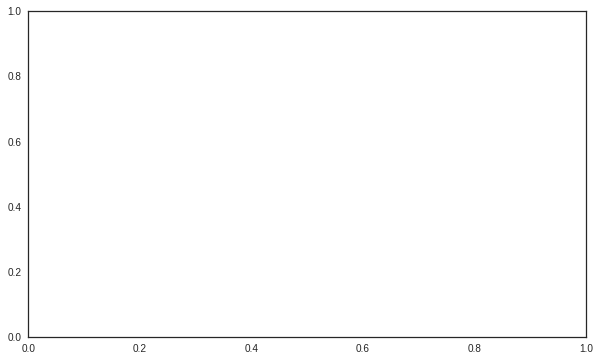

In [30]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [31]:
trace = mean_field.sample(100)

In [32]:
with neural_network:
    ppc = pm.sample_ppc(trace);

100%|██████████| 100/100 [00:01<00:00, 91.33it/s]


In [33]:

ppc['out']

array([[1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ..., 
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

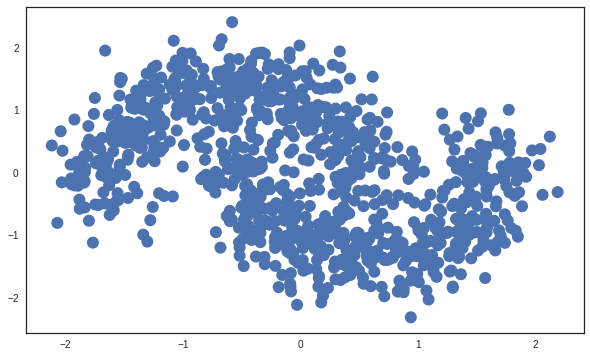

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.scatter(X[Y==0, 0], X[Y==0, 1])
#ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
ax.scatter(X[:, 0], X[:, 1], linewidths=out_sample.eval().std(axis=1) * 10)

In [35]:
Y_pred = np.mean(out_sample.eval(), axis=0)

In [36]:
out_sample.eval().std(axis=1).shape

(100,)

In [37]:
with neural_network:
    mean_field = pm.fit(method='advi', n=50000,
                       callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])
    approx = inference.approx
    test_probs = approx.sample_node(act_out, more_replacements={Xt: grid_2d})
    eval_tracker = pm.callbacks.Tracker(
        test_probs=test_probs.eval,
    )
    inference.fit(method='advi', n=50000,
                  callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative'),
                             eval_tracker])

Average Loss = 226.73: 100%|██████████| 50000/50000 [01:00<00:00, 833.09it/s]
Finished [100%]: Average Loss = 226.8


NameError: name 'inference' is not defined

In [38]:
with neural_network:
    inference = pm.ADVI()
    approx = inference.approx
    test_probs = approx.sample_node(p, more_replacements={Xt: grid_2d})
    eval_tracker = pm.callbacks.Tracker(
        test_probs=test_probs.eval,
    )
    inference.fit(method='advi', n=50000,
                  callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative'),
                             eval_tracker])

NameError: name 'p' is not defined

In [ ]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [ ]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train), 
    create_minibatch(Y_train),
)

total_size = len(Y_train)

In [ ]:
%%time

with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

In [ ]:
with neural_network:    
    trace = pm.variational.sample_vp(v_params, draws=5000)

In [ ]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

In [ ]:
pm.traceplot(trace);